# 🧠 Answer Synthesis from Multiple Sources
✅ What Is It?

Answer synthesis from multiple sources is the process where an AI agent collects information from different retrieval tools or knowledge bases, and merges that information into a single, coherent, and contextually rich answer.

This is a core capability in Agentic RAG, where the system is more than just a simple retriever — it plans, retrieves, and then synthesizes an answer that draws from multiple sources.

🎯 Why It’s Needed
Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response



## Setup and Import Libraries

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader, ArxivLoader, WikipediaLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o-mini")

## Create Retrievers

In [5]:
def load_text_retriever(file_path):
    documents = TextLoader(file_path, encoding="utf-8").load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = text_splitter.split_documents(documents=documents)
    vector_store = FAISS.from_documents(documents=chunks, embedding=embeddings)
    return vector_store.as_retriever()

In [6]:
def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    document = Document(page_content=content, metadata={"source": "youtube"})
    vector_store = FAISS.from_documents(documents=[document], embedding=embeddings)
    return vector_store.as_retriever()

In [7]:
def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())(query)

In [ ]:
def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    arxiv_api_wrapper = ArxivAPIWrapper(
        top_k_results=2, 
        doc_content_chars_max=500
    )
    return arxiv_api_wrapper.run(query=query)

In [9]:
text_retriever = load_text_retriever(file_path="internal_docs.txt")
youtube_retriever = load_youtube_retriever()

## Create State

In [10]:
class MultiSourceRAGState(BaseModel):
    question: str
    text_documents: List[Document] = []
    youtube_documents: List[Document] = []
    wikipedia_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

## Creating Nodes

### Retrieve Text Node

In [11]:
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    documents = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_documents": documents})

### Retrieve Youtube Node

In [12]:
def retrieve_youtube(state: MultiSourceRAGState) -> MultiSourceRAGState:
    documents = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"youtube_documents": documents})

### Retrieve Wikipedia Node

In [13]:
def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wikipedia_context": result})

### Retrieve Arxiv Node

In [14]:
def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

### Synthesize Answer Node

In [15]:
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([document.page_content for document in state.text_documents])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([document.page_content for document in state.youtube_documents])
    context += "\n\n[Wikipedia]\n" + state.wikipedia_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""
    You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

    Question: {state.question}

    Context:
    {context}

    Final Answer:
    """

    answer = llm.invoke(prompt).content.strip()
    
    return state.model_copy(update={"final_answer": answer})

## Graph Builder

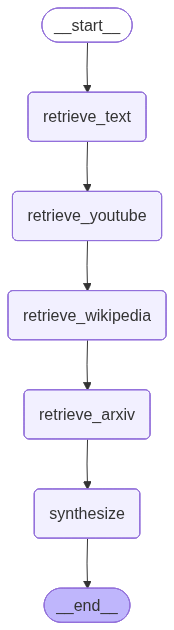

In [16]:
builder = StateGraph(MultiSourceRAGState)

# Add Nodes
builder.add_node(node="retrieve_text", action=retrieve_text)
builder.add_node(node="retrieve_youtube", action=retrieve_youtube)
builder.add_node(node="retrieve_wikipedia", action=retrieve_wikipedia)
builder.add_node(node="retrieve_arxiv", action=retrieve_arxiv)
builder.add_node(node="synthesize", action=synthesize_answer)

# Set Entry Point
builder.set_entry_point(key="retrieve_text")

# Add Edges
builder.add_edge(start_key="retrieve_text", end_key="retrieve_youtube")
builder.add_edge(start_key="retrieve_youtube", end_key="retrieve_wikipedia")
builder.add_edge(start_key="retrieve_wikipedia", end_key="retrieve_arxiv")
builder.add_edge(start_key="retrieve_arxiv", end_key="synthesize")
builder.add_edge(start_key="synthesize", end_key=END)

# Compile Graph
graph = builder.compile()

# Display Graph
graph

## Query

In [18]:
question = "What are transformer agents and how are they evolving in recent research?"

state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])

🌐 Searching Wikipedia...
📄 Searching ArXiv...
✅ Final Answer:

Transformer agents represent a significant evolution in the field of artificial intelligence, particularly as they showcase the integration of feedback loops, memory, and autonomous tasking capabilities. These agents are essentially advanced AI systems built upon the foundational architecture of transformers, which excel in tasks ranging from natural language processing to image and audio generation.

Recent research has led to substantial advancements and variants of the traditional transformer frameworks. One notable branch is vision transformers (ViT and Swin Transformers), which have been applied effectively in manufacturing quality control tasks. Similarly, speech transformers like Wav2Vec 2.0 are being benchmarked for voice assistant integrations, demonstrating the versatility of transformer models across different data types.

Optimization techniques have also emerged to enhance the efficiency and functionality of tr

In [19]:
result

{'question': 'What are transformer agents and how are they evolving in recent research?',
 'text_documents': [Document(id='0ea1fb83-6dde-4290-8b22-12aef431cfe5', metadata={'source': 'internal_docs.txt'}, page_content='Additional Notes:\n    - Vision transformers (ViT and Swin Transformer) evaluated in manufacturing QC tasks.\n    - Speech transformers (Wav2Vec 2.0) benchmarked for voice assistant integrations.\n    - Tokenizers: SentencePiece, BPE, and unigram tokenizers compared for multilingual tasks.\n    - Significant improvements noted with FlashAttention and Rotary Positional Encoding.'),
  Document(id='1e9e1b1b-3333-4c99-8403-ab8b071994f0', metadata={'source': 'internal_docs.txt'}, page_content='3. Reformer:\n    - Tested for memory efficiency on embedded devices.\n    - LSH attention led to 60% memory reduction.\n    - Integration challenges with standard transformers due to bucket collisions.\n    - Ongoing investigation for training stability and gradient clipping strategies.